In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [3]:
hbar = 1.05 * 10**(-34)
e = 1.6 * 10**(-19)
Phi0 = np.pi * hbar / e

# Objects

## Transmon

<img src="img/transmon.png" align="right" alt="Drawing" style="width: 400px;"/>

$E_{j1} = \cfrac{\hbar I_{j1}}{2e}$

$E_{j2} = \cfrac{\hbar I_{j2}}{2e}$ (если есть)

$\Phi_{ext} = MI$

$E_j = \sqrt{E_{j1}^2 + E_{j2}^2 + E_{j1}E_{j2}\cos(2e \Phi_{ext}/\hbar)}$

$E_c = \cfrac{e^2}{2(C + C_r + C_l + C_u)} = \cfrac{e^2}{2(C + C_{neighbours})}$

$\hbar \omega = \sqrt{(8 E_c E_j)}$

$E_{n-1, n} = \sqrt{(8 E_c E_j)} - E_cn$

In [4]:
class Transmon:
# properties
    # n - number of levels
    # psi - wave function
    # C capacity
    # Ej
    # Ec
    # w - array of freq 0-1, 1-2 ...
    # psi - wave function (defaulf [1, 0 , 0 ...])
    # what about gamma???
    
    def __init__(self, psi, C, Ij1, Ij2 = 0, M = 0, I = 0, Cnb = [0]):
        
        # number of levels
        self.n = len(psi)
        
        #C, Ej, Ec, w
        self.C = C
        Ej1 = hbar * Ij1 / (2 * e)
        Ej2 = hbar * Ij2 / (2 * e)
        Phiext = I * M
        self.Ej = np.sqrt(Ej1**2 + Ej2**2 + 2 * Ej1 * Ej2 * np.cos(2 * e / hbar * Phiext))
        self.Ec = e**2 / 2 / (C + np.sum(Cnb))
        self.w = np.zeros(self.n - 1)
        for i in range(1, self.n):
            self.w[i-1] = np.sqrt(8 * self.Ec * self.Ej) / hbar - self.Ec * i / hbar
            self.w[i-1] *= 10**(-9)

        
        #wave fucntion
        self.psi = np.array(psi, dtype = complex)
        if self.psi.size != self.n:
            print('error, wrong size of transmon.psi')
        self.psi = self.psi / np.linalg.norm(self.psi)
        self.psi.shape = (self.n, 1)

## Ocsillator

$\hbar \omega = \cfrac{\hbar}{\sqrt{LC}}$

$E_{n-1, n} = \hbar \omega$

In [5]:
class Oscillator:
# properties
    # n - number of levels
    # C - capacity
    # psi - wave function
    # w - array of freq 0-1, 1-2 ...
    # psi - wave function (defaulf [1, 0 , 0 ...])
    # what about gamma???
    
    def __init__(self, psi, C, L):
        
        # number of levels
        self.n = len(psi)
        
        #С, w
        self.C = C
        self.w = np.array([1/np.sqrt(L * C)] * (self.n - 1)) * 10**(-9)
        
        #wave fucntion
        self.psi = np.array(psi, dtype = complex)
        if self.psi.size != self.n:
            print('error, wrong size of oscillator.psi')
        self.psi = self.psi / np.linalg.norm(self.psi)
        self.psi.shape = (self.n, 1)

## Coupling

Пока совсем сыро
$G = \cfrac{C \sqrt{\omega_1\omega_2}}{2\sqrt{(C+C_1)(C+C_2)}}$

In [6]:
class Coupling():
    
    def __init__(self, C):
        self.C = C
        self.G = C / 2

## Circuit

In [7]:
# Для записи цепей. Цепь записывается через массив элементов цепи (вершины) и список ребер.
class Circuit():
    
# dt
# elements
# egdes
# psi
# psiwrite
# a 
# ad
# H
# Hwrite
# HwriteRWB
    
    def __init__(self, elements, edges, dt):
        self.dt = dt
        self.elements = np.asarray(elements)
        self.edges = np.asarray(edges)
        self.psi, self.psiwrite = CreatePsi(self)
        
        # находим константы связи G
        for i in range(0, self.elements.size):
            if self.elements[i].__class__.__name__ == 'Coupling':
                for j in range(0, self.edges.shape[0]):
                    if self.edges[j][0] == i:
                        tmp = self.edges[j][1]
                        self.elements[i].G *= np.sqrt(self.elements[tmp].w[0]/(self.elements[i].C \
                                                                                     + self.elements[tmp].C))
                    if self.edges[j][1] == i:
                        tmp = self.edges[j][0]
                        self.elements[i].G *= np.sqrt(self.elements[tmp].w[0]/(self.elements[i].C \
                                                                                     + self.elements[tmp].C))
                        
        self.a, self.ad = CreateAAd(self, RWB_time = 0.)
        self.H = CreateHamiltonian(self)
        self.Hwrite, self.HwriteRWB = CreateHamiltonianWrite(self)
        self.rwb, self.rwbd = CreateRWB(self)

# Operators (fuctions)

## CreatePsi

In [8]:
# волновая функиция по circuit 
def CreatePsi(circuit):
    psi = np.array([], dtype = complex)
    psiwrite = chr(936) + ' = '
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__:
            if psi.size == 0:
                psi = circuit.elements[i].__dict__.get('psi')
                psiwrite = psiwrite + chr(936) + str(i)
            else:
                psi = np.kron(psi, circuit.elements[i].__dict__.get('psi'))
                psiwrite = psiwrite + chr(8855) + chr(936) + str(i)
    return(psi, psiwrite)

## CreateAAd

In [9]:
# операторы рождения и уничтожения по circuit
# RWB = 0. - не учитывается RWB
# RWB = 1. - учитывается (1 число шагов по времени)
def CreateAAd(circuit, RWB_time):
    n = circuit.psi.size
    a = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    ad = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    cnt = 1
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            if cnt == 1:
                tmpa = np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex), k = 1))
                tmpad = tmpa.transpose()
            else:
                tmpa = np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex), k = 1))
                tmpad = tmpa.transpose()
                tmpa = np.kron(np.identity(cnt), tmpa)
                tmpad = np.kron(np.identity(cnt), tmpad)
            cnt *=  circuit.elements[i].n
            if cnt < circuit.psi.size:
                tmpa = np.kron(tmpa, np.identity(circuit.psi.size // cnt))
                tmpad = np.kron(tmpad, np.identity(circuit.psi.size // cnt))
            a[i] = tmpa
            ad[i] = tmpad
    return(a, ad)

In [10]:
# операторы рождения и уничтожения по circuit
# RWB = 0. - не учитывается RWB
# RWB = 1. - учитывается (1 число шагов по времени)
def CreateAAdOld(circuit, RWB_time):
    n = circuit.psi.size
    a = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    ad = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    cnt = 1
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            if cnt == 1:
                tmpa = np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex)*\
                                       np.exp(- 1j * circuit.elements[i].w * RWB_time), k = 1))
                tmpad = np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex)*\
                                       np.exp(1j * circuit.elements[i].w * RWB_time), k = 1).transpose())
            else:
                tmpa = np.kron(np.identity(cnt), np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex)*\
                                       np.exp(- 1j * circuit.elements[i].w * RWB_time), k = 1)))
                tmpad = np.kron(np.identity(cnt), np.sqrt(np.diag(np.arange(1, circuit.elements[i].n, dtype = complex)*\
                                       np.exp(1j * circuit.elements[i].w * RWB_time), k = 1).transpose()))
            cnt *=  circuit.elements[i].n
            if cnt < circuit.psi.size:
                tmpa = np.kron(tmpa, np.identity(circuit.psi.size // cnt))
                tmpad = np.kron(tmpad, np.identity(circuit.psi.size // cnt))
            a[i] = tmpa
            ad[i] = tmpad
    return(a, ad)

In [11]:
def CreateRWB(circuit):
    n = circuit.psi.size
    rwb = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    rwbd = np.stack([np.identity(n, dtype = complex)] * circuit.elements.size)
    cnt = 1
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            if cnt == 1:
                tmpa = np.diag(np.append(np.zeros(1), np.exp(- 1j * circuit.elements[i].w * circuit.dt)))
                tmpad = np.diag(np.append(np.exp(1j * circuit.elements[i].w * circuit.dt), np.zeros(1)))
            else:
                tmpa = np.diag(np.append(np.zeros(1), np.exp(- 1j * circuit.elements[i].w * circuit.dt)))
                tmpad = np.diag(np.append(np.exp(1j * circuit.elements[i].w * circuit.dt), np.zeros(1)))
                tmpa = np.kron(np.identity(cnt), tmpa)
                tmpad = np.kron(np.identity(cnt), tmpad)
            cnt *=  circuit.elements[i].n
            if cnt < circuit.psi.size:
                tmpa = np.kron(tmpa, np.identity(circuit.psi.size // cnt))
                tmpad = np.kron(tmpad, np.identity(circuit.psi.size // cnt))
            rwb[i] = tmpa
            rwbd[i] = tmpad
    return(rwb, rwbd)

## CreateHamiltonian

In [37]:
# по circuit выводит гамильтониан системы
def CreateHamiltonian(circuit):
    H = np.zeros((circuit.psi.size, circuit.psi.size), dtype = complex)
    for i in range(0, circuit.elements.size):
        if circuit.elements[i].__class__.__name__ == 'Coupling':
            for j in range(0, circuit.edges.shape[0]):
                if circuit.edges[j][0] == i:
                    tmp = circuit.edges[j][1]
                    tmpH1 = circuit.ad[tmp] + circuit.a[tmp]
                if circuit.edges[j][1] == i:
                    tmp = circuit.edges[j][0]
                    tmpH2 = circuit.ad[tmp] + circuit.a[tmp]
            H = H + circuit.elements[i].G * np.dot(tmpH1, tmpH2)
    return (H)

In [13]:
def CreateHamiltonianWrite(circuit):
    Hwrite = 'H = '
    HwriteRWB = 'H_RWB = '
    for i in range(0, circuit.elements.size):
        if circuit.elements[i].__class__.__name__ == 'Transmon' or\
           circuit.elements[i].__class__.__name__ == 'Oscillator':
            Hwrite = Hwrite + ' + \u0127\u03C9_' + str(i) + 'a' + chr(8314) + '_' + str(i) + 'a_' + str(i)
        if circuit.elements[i].__class__.__name__ == 'Coupling':
            Hwrite = Hwrite + ' + \u0127g_' + str(i)
            HwriteRWB = HwriteRWB + ' + \u0127g_' + str(i)
            for j in range(0, circuit.edges.shape[0]):
                if circuit.edges[j][0] == i:
                    tmp = circuit.edges[j][1]
                    Hwrite = Hwrite + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
                    HwriteRWB = HwriteRWB + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
                if circuit.edges[j][1] == i:
                    tmp = circuit.edges[j][0]
                    Hwrite = Hwrite + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
                    HwriteRWB = HwriteRWB + '(' + 'a' + chr(8314) + '_' + str(tmp) + ' + a_' + str(tmp) + ')'
    return (Hwrite, HwriteRWB)

## RK4

In [62]:
# evolution for RK4
def FuncEvolution(psi, circuit):
    dpsi = 1j * np.dot(circuit.H, psi)
    return(dpsi)

def RK4(circuit, RWB_time):
    k1 = FuncEvolution(circuit.psi, circuit)
    k2 = FuncEvolution(circuit.psi + circuit.dt/2 * k1, circuit)
    k3 = FuncEvolution(circuit.psi + circuit.dt/2 * k2, circuit)
    k4 = FuncEvolution(circuit.psi + circuit.dt * k3, circuit)
    circuit.psi = (circuit.psi + circuit.dt/6 * (k1 + 2*k2 + 2*k3 + k4))
    circuit.psi = circuit.psi / np.linalg.norm(circuit.psi)
    
    #recount annihilation and creation operatored due to RWB
    #circuit.a, circuit.ad = CreateAAd(circuit, RWB_time)
    for i in range(0, circuit.elements.size):
        if 'psi' in circuit.elements[i].__dict__: 
            circuit.a[i] = np.dot(circuit.a[i], circuit.rwb[i])
            circuit.ad[i] = np.dot(circuit.ad[i], circuit.rwbd[i])
    
    
    #recount Hamiltonian
    circuit.H = CreateHamiltonian(circuit)
            
    return(circuit)

# Testing

## transmon

In [15]:
#проверка работы Transmon
C = 5*10**(-14)
Ij = 40*e**3/hbar/C

transmon = Transmon(psi = [1, 1], C = C, Ij1 = Ij, Ij2 = 0)
print(transmon.w/2/np.pi, 'GHz')
print(transmon.Ej/transmon.Ec)
print(transmon.psi)

[6.55334456] GHz
40.00000000000001
[[0.70710678+0.j]
 [0.70710678+0.j]]


## oscillator

In [16]:
L = 2 * 10**(-8)
osc = Oscillator(psi = [1, 0, 0], L = L, C = C)
print(osc.w / 2 / np.pi, 'GHz')
print(osc.psi)

[5.03292121 5.03292121] GHz
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]]


## coupling

In [17]:
coupling = Coupling(C/10)

## circuit

In [27]:
transmon = Transmon(psi = [1, 1, 0], C = C, Ij1 = Ij, Ij2 = 0)
coupling = Coupling(C /100/2)
osc = Oscillator(psi = [1, 0, 0], L = L, C = C)
dt = 0.01


circuit = Circuit([transmon, coupling, osc],  [[0, 1], [1, 2]], dt = dt)
print(circuit.psiwrite)
print(circuit.psi)
print(circuit.Hwrite)
print(circuit.HwriteRWB)
print(circuit.elements[1].G/ 2/np.pi)

Ψ = Ψ0⊗Ψ2
[[0.5+0.j]
 [0. +0.j]
 [0.5+0.j]
 [0.5+0.j]
 [0. +0.j]
 [0.5+0.j]
 [0. +0.j]
 [0. +0.j]
 [0. +0.j]]
H =  + ħω_0a⁺_0a_0 + ħg_1(a⁺_0 + a_0)(a⁺_2 + a_2) + ħω_2a⁺_2a_2
H_RWB =  + ħg_1(a⁺_0 + a_0)(a⁺_2 + a_2)
0.014286160145856078


In [60]:
Time = 10
dt = 0.01
time = np.linspace(0, Time, Time // dt + 1)

transmon = Transmon(psi = [1, 1, 0], C = C, Ij1 = Ij, Ij2 = 0)
coupling = Coupling(C /100/2)
osc = Oscillator(psi = [1, 0, 0], L = L, C = C)
circuit = Circuit([transmon, coupling, osc],  [[0, 1], [1, 2]], dt = dt)
print(circuit.elements[0].w / 2 / np.pi, 'GHz, Trans')
print(circuit.elements[2].w / 2 / np.pi, 'GHz, Osc')
print(circuit.elements[1].G / 2 / np.pi, 'GHz, G')


x0 = np.zeros((len(time)), dtype = complex)
y0 = np.zeros((len(time)), dtype = complex)
z0 = np.zeros((len(time)), dtype = complex)
z2 = np.zeros((len(time)), dtype = complex)


x0[0] = np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[0] + circuit.a[0]), circuit.psi))
y0[0] = 1j * np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[0] - circuit.a[0]), circuit.psi))
z0[0] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[0], np.dot(circuit.a[0], circuit.psi)))
z2[0] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[2], np.dot(circuit.a[2], circuit.psi)))

for i in range(1, len(time)):
    circuit = RK4(circuit, 0)
    x0[i] = np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[0] + circuit.a[0]), circuit.psi))
    y0[i] = 1j * np.dot(np.conj(circuit.psi.transpose()), np.dot((circuit.ad[0] - circuit.a[0]), circuit.psi))
    z0[i] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[0], np.dot(circuit.a[0], circuit.psi)))
    z2[i] = np.dot(np.conj(circuit.psi.transpose()), np.dot(circuit.ad[2], np.dot(circuit.a[2], circuit.psi)))

[6.55334456 6.16530965] GHz, Trans
[5.03292121 5.03292121] GHz, Osc
0.014286160145856078 GHz, G


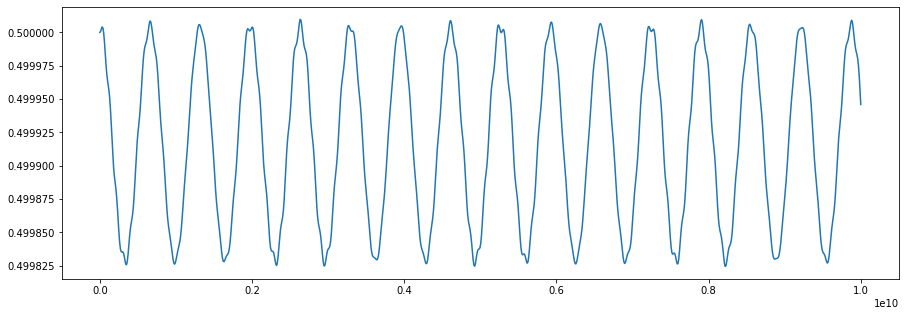

In [61]:
plt.figure(figsize=(15,5))
#plt.plot(time*10**(9), x0)
#plt.plot(time*10**(9), y0)
plt.plot(time*10**(9), z0)
#plt.plot(time*10**(9), z2)
plt.show()